In [1]:
# TODO: Bollinger charts with colors reflecting MACD
# TODO: drop ticker if no data today
# TODO: 60 day lowest predict <- Bollinger bands for Low
# TODO: github for ipynb project
############
# https://stackoverflow.com/questions/69800749/using-python-to-get-holdings-and-allocation-of-etfs
# conda env create -f environment.yml
# conda install -f environment.yml
# conda update -n base conda
# conda env update --file environment.yml --prune
# print("https://www.etfdb.com")
print("https://www.etfrc.com/funds/overlap.php")
TRADITIONAL = 'VYM VOT MGK VIG VGT VOO VDE VCR VHT VFH VUG'
# "AIRR CLSE CRPT HTUS IGM KBWP MGK PAVE PKB RSHO SLX SPSM VCR VDE VFH VGT VHT VIG VOO VOT VUG VYM XBI XHB"
ROTH = 'SPYG SCHG QQQ VGT CRPT IGM PAVE PKB XHB' # Roth 2024.03.14. 04.01 -IVW VOO MGK VTI IUSG VUG

BASE = 'VOT VOO VTI FLMVX FXAIX'
CONSTRUCTION = 'AIRR PKB XHB ITB'
GROWTH = 'MGK VGT VUG QQQ IVW SCHG SPYG IUSG FCNKX JDMNX MITJX VIGIX'
DIV = 'VYM VIG'
ENERGY = 'AMZA URNM VDE'
INSURANCE = 'KBWP'
SECTORS = 'VOX VCR VDC VFH VHT VIS VAW VPU RSHO PRN'
INTERNATIONALS = 'VEU VSS VEA VWO VGK VPL VNQI VXUS VT'
CRYPTO = 'CRPT'# DAPP BITQ BKCH SATO WGMI IBLC # BITX (2023-06-27) GBTC IBIT (2024-1-11)
INFRA = 'PAVE'# IGF IFRA NFRA EMIF RBLD
AI = 'IGM IYW FTEC FDN'

BENCH = 'VOO CRPT SPSM TSLA'# KBWP PAVE IGM VGT QMOM URNM AMZA PKB=XHB SLX
TEST = BENCH + 'CLSE XBI IAI KCE HTUS PSP XMMO XSMO UTES AIRR PKB KBWP PAVE XHB' #HRTS CBLS USE GCAD SLX VDE
TEST = BENCH 
start = '2020-11-03'

https://www.etfrc.com/funds/overlap.php


In [2]:
# Import libraries and pull data
import datetime
import warnings
import re
import json
import textwrap
import numpy as np
import pandas as pd
import yfinance as yf
#import quantstats as qs
import matplotlib.pyplot as plt
import seaborn as sns
import cufflinks as cf
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from ipywidgets import widgets, interact, interactive
from scipy import stats
#from sklearn.preprocessing import MinMaxScaler, StandardScaler
#from keras.models import Sequential
#from keras.layers import Dense, LSTM, Activation
from IPython.display import display, clear_output, HTML
from yahooquery import Ticker, Screener
from pyvis import network as net
import networkx as nx

cf.go_offline()
pio.renderers.default = 'iframe'
plt.style.use('dark_background')
warnings.filterwarnings("ignore", category=FutureWarning, module="yfinance")
warnings.filterwarnings("ignore", category=FutureWarning, module="cufflinks")
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")
warnings.filterwarnings("ignore", "warn_singular")
warnings.simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
template = 'plotly_dark'
pd.options.display.float_format = "{:,.2f}".format

EPOCH=64
EPOCH=32
NOP = 20000 # Number of random portfolio sets
risk_free_return = .05
model = 'Sharpe'
categories = {
    "ai": AI,
    "base": BASE,
    "construction": CONSTRUCTION,
    "crypto": CRYPTO,
    "div": DIV,
    "energy": ENERGY,
    "growth": GROWTH,
    "infra": INFRA,
    "insurance": INSURANCE,
    "internationals": INTERNATIONALS,
    "sectors": SECTORS,
}

In [3]:
def price_bands(period = 42, multiplier = 1.8): # Calculate price bands
    global idx
    
    std = idx['Adj Close'].rolling(window=period).std()
    std.columns = pd.MultiIndex.from_product([['STD'], std.columns])
    idx = idx.join(std)
    
    ma = idx['Adj Close'].rolling(window=period).mean()
    ma.columns = pd.MultiIndex.from_product([['MA'], ma.columns])
    idx = idx.join(ma)
    
    uband = idx['MA'] + multiplier * idx['STD']
    uband.columns = pd.MultiIndex.from_product([['UBAND'], uband.columns])
    idx = idx.join(uband)
    
    lband = idx['MA'] - multiplier * idx['STD']
    lband.columns = pd.MultiIndex.from_product([['LBAND'], lband.columns])
    idx = idx.join(lband)    
    
    emaw = idx['Adj Close'].ewm(span=5, adjust=False).mean()
    emaw.columns = pd.MultiIndex.from_product([['EMAW'], emaw.columns])
    idx = idx.join(emaw)
    
    emam = idx['Adj Close'].ewm(span=21, adjust=False).mean()
    emam.columns = pd.MultiIndex.from_product([['EMAM'], emam.columns])
    idx = idx.join(emam)

    strength = 2 * (idx['Adj Close'] - idx['UBAND']) / (idx['UBAND'] - idx['LBAND']) + 1
    strength.columns = pd.MultiIndex.from_product([['strength'], strength.columns])
    idx = idx.join(strength)
    
    # Moving Average Convergence Divergence
    mdl = idx['EMAM'] - idx['EMAW']
    sgl = mdl.ewm(span=16, adjust=False).mean()
    mdh = sgl - mdl

    columns = idx['Low'].columns
    mdl.columns = pd.MultiIndex.from_product([['MACD_Line'], columns])
    sgl.columns = pd.MultiIndex.from_product([['Signal_Line'], columns])
    mdh.columns = pd.MultiIndex.from_product([['MACD'], columns])
    
    idx = idx.join(mdl)
    idx = idx.join(sgl)
    idx = idx.join(mdh)

    # Relative Strength Index
    rsi = calculate_rsi(idx)/25-2
    rsi.columns = pd.MultiIndex.from_product([['RSI'], columns])
    idx = idx.join(rsi)
    
    # Adding signals for buy/ sell
    sgn = pd.DataFrame(np.where(idx['EMAW'] > idx['EMAM'], 1.0, 0.0), columns=columns, index=idx['EMAW'].index)
    sgn.columns = pd.MultiIndex.from_product([['signal'], columns])
    pos = sgn.diff().fillna(0)
    pos.columns = pd.MultiIndex.from_product([['position'], columns])
    idx = idx.join(pos)

    summary['UBAND'] = idx['UBAND'].iloc[-1]
    summary['Adj Close'] = idx['Adj Close'].iloc[-1]
    summary['LBAND'] = idx['LBAND'].iloc[-1]
    # summary['strength'] = idx['strength'].iloc[-1]
    # summary['RSI'] = idx['RSI'].iloc[-1]
    # summary['MACD'] = idx['MACD'].iloc[-1]

    for indicator in ['MACD', 'RSI']:
        summary[f"{indicator}_prc"] = 100 - (idx[indicator] < idx[indicator].iloc[-1]).mean() * 100

def calculate_rsi(data, window=10):
    delta = data['Adj Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def get_model(x_train, y_train):
    pred_model = Sequential()
    pred_model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    pred_model.add(LSTM(50, return_sequences=False))
    # pred_model.add(Dense(25))
    pred_model.add(Dense(25, activation='relu'))
    pred_model.add(Dense(1))
    pred_model.compile(optimizer='adam', loss='mean_squared_error')
    pred_model.fit(x_train, y_train, batch_size=32, epochs=EPOCH, verbose=0)
    return pred_model

def get_predictions(scaler, scaled_data):
    # Create the testing data set
    # Create a new array containing scaled values 
    test_data = scaled_data[training_data_len - 60: , :]
    x_test, y_test = [], dataset[training_data_len:, :]
    for i in range(60, len(test_data)):
        x_test.append(test_data[i-60:i, 0])
        
    # Convert the data to a numpy array
    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1)) # Reshape the data
    # Get the models predicted price values 
    predictions = pred_model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)
    rmse = np.sqrt(np.mean(((predictions - y_test) ** 2))) # root mean squared error
    return (predictions, rmse)

def get_train():
    # Scale the data
    scaler = MinMaxScaler(feature_range=(0,1))
    # scaler = StandardScaler()

    scaled_data = scaler.fit_transform(dataset)
    # Create the scaled training data set
    train_data = scaled_data[0:int(training_data_len), :]
    # Split the data into x_train and y_train data sets
    x_train, y_train = [], []
    for i in range(60, len(train_data)):
        x_train.append(train_data[i-60:i, 0])
        y_train.append(train_data[i, 0])
    # Convert the x_train and y_train to numpy arrays 
    x_train, y_train = np.array(x_train), np.array(y_train)
    # Reshape the data
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    return (x_train, y_train, scaler, scaled_data)

def get_data(fund):
    #Create a new dataframe with only one data column
    data = prices.filter([fund])
    #Convert the dataframe to a numpy array
    dataset = data.values
    #Get the number of rows to train the model on
    training_data_len = int(np.ceil(len(dataset) * .8))
    training_data_len
    return (data, dataset, training_data_len)

def ann_risk_return(df):
    rdf = df.agg(["mean", "std"]).T
    rdf.columns = ["Return", "Risk"]
    rdf.Return = (df.iloc[-1] / df.iloc[0]) ** (1/(((df.index[-1]-df.index[0]).days)/365)) - 1
    rdf.Risk = rdf.Risk * np.sqrt(252)
    return rdf

def get_sortino(df):
    returns = df.pct_change(1).dropna()
    downside_returns = returns[returns < 0]
    downside_std = np.std(downside_returns, axis=0)
    sortino_ratio = returns.mean() / downside_std
    return sortino_ratio

def get_parent(ticker):
    for parent in categories:
        if ticker in (categories[parent]).split():
            return parent
    return summary.loc[ticker,'category']

def h_max(s):
    try:
        is_max = s.astype('float') == s.max()
        return ['color: green' if cell else '' for cell in is_max]
    except:
        return ['' for cell in s]

def h_min(s):
    try:
        is_min= s.astype('float') == s.min()
        return ['color: blue' if cell else '' for cell in is_min]
    except:
        return ['' for cell in s]

def h_bull(s):
    try:
        is_bs = s.astype('str').str.contains('ullish') & ~s.astype('str').str.contains('earish') & ~s.astype('str').str.contains('Weak') & ~s.astype('str').str.contains(' one ')
        return ['color: green' if cell else '' for cell in is_bs]
    except:
        return ['' for cell in s]

def h_bear(s):
    try:
        is_bs = s.astype('str').str.contains('earish') & ~s.astype('str').str.contains('ullish') & ~s.astype('str').str.contains('Weak') & ~s.astype('str').str.contains(' one ')
        return ['color: red' if cell else '' for cell in is_bs]
    except:
        return ['' for cell in s]

In [4]:
tix = " ".join(sorted(set(TEST.split())))
kw = {'start': start}
end = datetime.datetime.now().strftime("%Y-%m-%d")
idx = yf.download(tix, **kw)
idx.index = idx.index.date
if idx['Adj Close'].index[0] != idx['Adj Close'].dropna().index[0]:
    start = idx['Adj Close'].dropna().index[0]
    print(f"\nCommon start: {start}")
    display(idx['Adj Close'][:start].fillna(''))
    idx=idx.loc[start:]
# FIXME: Warning: some futures ETFs show NaN for current trading day
adj_prices = idx['Adj Close'].copy()
if any(adj_prices.iloc[-1].isna()):
    print("Missing data from today!!!" + 10*"\n")
display(100*adj_prices.pct_change(1, fill_method=None).tail())
# idx.dropna(inplace=True) # Crypto currency trades when stock market is closed




prices = idx['Adj Close'].div(idx['Adj Close'].iloc[0]).mul(100)
summary = pd.DataFrame(index=idx['Adj Close'].columns)
tickers = {n: Ticker(n) for n in summary.index}
funds = {n: t.all_modules[n] for n, t in tickers.items()}
holdings = {fund:funds[fund]["topHoldings"]['holdings'] for fund in funds if funds[fund].get('topHoldings')}
recommendations = {n: t.recommendations for n, t in tickers.items()}
insights = {n: t.technical_insights[n] for n, t in tickers.items()}
ret = prices.pct_change().dropna()
types = []
for fund in funds:
    if 'CRYPTOCURRENCY' == funds[fund]["quoteType"]['quoteType']: # Crypto
        types.append(funds[fund]["quoteType"]['quoteType'])
    elif 'ETF' == funds[fund]["quoteType"]['quoteType']:
        types.append(funds[fund]["fundProfile"]['categoryName'])
    else: #'EQUITY' == funds[fund]["quoteType"]['quoteType'] = Stock
        types.append(funds[fund]["assetProfile"]['sector'])
summary['category'] = types

summary = pd.concat((summary, ann_risk_return(prices.div(100))), axis=1)
summary['trailingPE'] = [funds[fund]["summaryDetail"].get('trailingPE',0) for fund in funds]
summary["Sharpe"] = (summary["Return"].sub(risk_free_return))/summary["Risk"]
summary["TotalRisk"] = np.power(summary.Risk, 2)
summary["SystRisk"] = (prices.div(100).cov()*252).loc[:,'VOO' if 'VOO' in prices.columns else prices.columns[-1]]
summary["UnsystRisk"] = summary["TotalRisk"].sub(summary["SystRisk"])
json_struct = json.loads(pd.DataFrame(insights).drop(['upsell', 'symbol'], errors='ignore').T.to_json(orient="records"))
df_flat = pd.json_normalize(json_struct)
df_flat.drop([c for c in df_flat.columns if c.endswith(('.provider', '.indexDirection', '.direction', '.score', '.indexScore',
        'sigDevs', 'events', 'secReports', 'projectionValuesCat', 'reports', '.reportId', '.researchReports.title', 'companySnapshot'))],
        axis=1, inplace=True)
df_flat.columns= [c.replace('instrumentInfo.', '') for c in df_flat.columns]
df_flat.columns= [c.replace('technicalEvents.', '') for c in df_flat.columns]
df_flat.columns= [c.replace('keyTechnicals.', '') for c in df_flat.columns]
df_flat.index = summary.index
df_flat = df_flat.T
df_flat = pd.concat((df_flat, pd.DataFrame(
    {fund['quoteType']['symbol']:
    {'annualReportExpenseRatio': fund.get('fundProfile',{}).get('feesExpensesInvestment',{}).get('annualReportExpenseRatio',0)}
    for fund in funds.values()}
)))
display(HTML("<style>:root { --jp-notebook-max-width: 96% !important; }</style>"))

noa = len(prices.columns)
np.random.seed(NOP)
matrix = np.random.random(noa*NOP).reshape(NOP, noa)
weights = matrix / matrix.sum(axis=1, keepdims=True)
port_ret = prices.div(100).dot(weights.T) # port_ret = ret.dot(weights.T)
port_summary = ann_risk_return(port_ret)
port_summary["Sharpe"] = (port_summary["Return"].sub(risk_free_return))/port_summary["Risk"]
port_summary["Sortino"] = get_sortino(port_ret.iloc[:,:-1])
msrp = port_summary.Sharpe.idxmax()
msrp1 = port_summary.Sortino.idxmax()
msrp_w = weights[msrp, :]
msrp1_w = weights[msrp1, :]
category = [get_parent(tick) for tick in list(prices.columns[:len(msrp_w)])]
summary['category'] = category
if len(prices.columns) == len(msrp_w):
    prices['sharpe'] = (prices * msrp_w).sum(axis=1)
if len(prices.columns) > len(msrp1_w):
    msrp1_w = np.append(msrp1_w, 0)
    prices['sortino'] = (prices * msrp1_w).sum(axis=1)
summary['weight'] = msrp_w*100
summary['weight1'] = msrp1_w[:summary.shape[0]]*100
pole = "VOO" if "VOO" in prices.columns else prices.columns[0]
summary["beta"] = summary.SystRisk / summary.loc[pole, "SystRisk"]
summary["capm_ret"] = risk_free_return + (summary.loc[pole, "Return"] - risk_free_return) * summary.beta
summary["alpha"] = summary.Return - summary.capm_ret
# summary = pd.concat((summary, df_flat.iloc[-4:].T), axis=1) # First, we add stopLoss, resistance, support...
summary = pd.concat((summary, df_flat.iloc[:-4].T), axis=1) # Next, analysts outlook
price_bands() # Calculate price bands

[*********************100%***********************]  4 of 4 completed


Common start: 2021-09-21


Ticker,CRPT,SPSM,TSLA,VOO
2020-11-03,,27.63,141.30,290.58
2020-11-04,,27.35,140.33,297.12
2020-11-05,,28.09,146.03,302.94
2020-11-06,,27.84,143.32,302.90
2020-11-09,,29.18,140.42,306.68
...,...,...,...,...
2021-09-15,,40.50,251.94,391.98
2021-09-16,,40.41,252.33,391.30
2021-09-17,,40.40,253.16,387.47
2021-09-20,,39.65,243.39,381.14


Ticker,CRPT,SPSM,TSLA,VOO
2024-11-08,3.60,0.58,8.19,0.44
2024-11-11,12.97,1.51,8.96,0.08
2024-11-12,-0.90,-1.55,-6.15,-0.30
2024-11-13,-8.25,-0.79,0.53,0.05
2024-11-14,-2.29,-1.09,-4.75,-0.34


In [6]:
x=-1 # Use latest day's data
g = px.scatter(
    summary, y='RSI_prc', x='MACD_prc', hover_name=summary.index,
    color=idx['Adj Close'].pct_change().iloc[x].values*100, color_continuous_scale='RdYlGn', color_continuous_midpoint=0.0,
    title='RSI vs Convergence frequency', template=template, text=summary.index
)

kw = dict(
    symbol=np.where(idx['Adj Close'].pct_change().iloc[x] > 0, 'triangle-up', 'triangle-down'),
    size=(2*idx['Adj Close'].pct_change().iloc[x] / idx['Adj Close'].pct_change().std())**2+2,
    line=dict(width=3, color=idx['RSI'].iloc[x], cmax=2, cmin=-2, colorscale="RdYlGn")
)
g.update_traces(textfont=dict(color='rgba(255, 255, 255, 0.25)'), textposition='top center', marker=kw)#, hovertemplate=s+'=%{y}<extra></extra>'

In [7]:
a=[]
for fund in funds:
    hold_sum = 0
    t = None
    for t in funds[fund].get('topHoldings',{}).get('holdings',{}):
        t['etf'] = fund
        t['category'] = summary.loc[fund, 'category']
        t['weight']=summary.loc[fund, 'weight' if model=='Sharpe' else 'weight1']
        t['holding'] = t['weight'] * t['holdingPercent']
        hold_sum += t['holdingPercent']
        t['Return'] = summary.loc[fund, 'Return'] #* 100
        # t['premium'] = summary.loc[fund, 'premium']
        # t['rmse'] = summary.loc[fund, 'rmse']
        # t['color'] = t['premium'] / t['rmse']
        # t['color'] = summary.loc[fund, 'Return']
        t['color'] = 2-summary.loc[fund, 'RSI_prc']/25
        a.append(t)
    z={}
    z['holdingName'] = '<other>'
    z['etf'] = fund
    z['category'] = summary.loc[fund, 'category']
    z['weight']=summary.loc[fund, 'weight' if model=='Sharpe' else 'weight1']
    z['holding'] = t['weight'] * (1-hold_sum) if t else 1
    z['Return'] = summary.loc[fund, 'Return'] #* 100
    # z['premium'] = summary.loc[fund, 'premium']
    # z['rmse'] = summary.loc[fund, 'rmse']
    z['color'] = 2-summary.loc[fund, 'MACD_prc']/25
    a.append(z)

tree = pd.DataFrame(a)
fig = px.treemap(tree, title=f"{model} Portfolio Structure", path=['category', 'etf', 'holdingName'], values='holding', #labels="parent",
         hover_name='etf',
         hover_data=['Return', 'color'],
         color_continuous_midpoint=0, color_continuous_scale="Temps", color='color', range_color=(-2,2))
fig.update_layout(margin=dict(l=10, r=10, b=10, t=30), template=template)
fig.update_traces(marker=dict(cornerradius=5))
fig.show()

In [8]:
df = {}
titles = []
sortval = summary['MACD_prc'] * summary['RSI_prc']/100
for title in sortval.sort_values(ascending=False).index:
    titles.append("{} {:.1f}%".format(title, sortval.loc[title]))
    titles.append(None)
kw=dict(
    rows=2*summary['MACD_prc'].size,
    cols=1,
    shared_xaxes=True,
    vertical_spacing=.01,
    horizontal_spacing=.01,
    row_heights=summary['MACD_prc'].size*[300, 100],
    subplot_titles=titles
)
fig = make_subplots(**kw)
for j, v in enumerate(sortval.sort_values(ascending=False).index):
    df[v] = idx.swaplevel(0, 1, axis=1)[v]
    # bollinger bands
    metrics = ['UBAND', 'LBAND']
    line_colors = ['#c0c0c0', '#c0c0c0']
    opacity = [.25, .25]
    for i, metric in enumerate(metrics):
        g = px.line(df[v], x=df[v].index, y=metric)
        g.update_traces(line_color=line_colors[i], opacity=opacity[i], hovertemplate=metric+'=%{y}<extra></extra>')
        fig.add_trace(g.data[0], row=1+2*j, col=1)
    metrics = ['Adj Close']
    opacity = [1]
    for i, metric in enumerate(metrics):
        rsi2 = (.25*df[v]['RSI'].fillna(1))**2
        g = px.scatter(df[v], x=df[v].index, y=metric, size=rsi2)
        g.update_traces(line_color=line_colors[i], opacity=opacity[i], hovertemplate=metric+'=%{y}<extra></extra>', marker_color=np.where(df[v]['MACD'] > 0, 'red', 'green'))#, marker={'size':4})
        fig.add_trace(g.data[0], row=1+2*j, col=1)

    # Buy/ sell signals
    for s, n in {'sell': 1, 'buy': -1}.items():
        g = px.scatter(df[v].loc[df[v].position == n], y=df[v].loc[df[v].position == n]['Adj Close'])
        kw = dict(symbol="triangle-up" if n==-1 else "triangle-down", line=dict(width=1, color="green" if n==-1 else "red"))
        g.update_traces(marker=kw, hovertemplate=s+'=%{y}<extra></extra>')
        fig.add_trace(g.data[0], row=1+2*j, col=1)
    # # Strength/ Relative Strength index
    # g = px.line(df[v], x=df[v].index, y='strength')
    # g.update_traces(hovertemplate='strength=%{y}<extra></extra>', line={'width': 1, 'color': 'silver'})
    # fig.add_trace(g.data[0], row=2+2*j, col=1)

    g = px.line(df[v], x=df[v].index, y='RSI')
    g.update_traces(hovertemplate='RSI=%{y}<extra></extra>', line={'width': 1, 'color': 'orange'})
    fig.add_trace(g.data[0], row=2+2*j, col=1)
    # Convergence/ divergence
    g = px.bar(df[v], x=df[v].index, y='MACD')
    g.update_traces(marker_color=np.where(df[v]['MACD'] > 0, 'red', 'green'), hovertemplate='MACD=%{y}<extra></extra>')
    fig.add_trace(g.data[0], row=2+2*j, col=1)
    fig.update_yaxes(type="log", row=1+2*j, col=1)
    fig.update_yaxes(range=[-2,2], row=2+2*j, col=1)

kw = dict(
    margin=dict(l=10, r=10, b=10, t=10),
    template=template,
    height=400*j,
    width=900,
    hovermode='x unified',
    legend_traceorder="normal",
    spikedistance=5,
    xaxis=dict(spikecolor="white", spikethickness=.25, spikedash='dash', spikemode='toaxis+across+marker')
)
fig.update_layout(**kw)
fig.show();

In [9]:
df[v]['RSI']

2021-09-21    NaN
2021-09-22    NaN
2021-09-23    NaN
2021-09-24    NaN
2021-09-27    NaN
             ... 
2024-11-08   0.87
2024-11-11   0.98
2024-11-12   0.92
2024-11-13   0.66
2024-11-14   0.88
Name: RSI, Length: 794, dtype: float64

In [10]:
summary['url'] = summary.index
summary["url"] = summary.apply(lambda row: "<a href='https://www.etfdb.com/etf/{}/#holdings' target='_blank'>{}</a>".format(row.url, row.url), axis=1)
display(HTML(summary.infer_objects(copy=False).fillna('').T.style.apply(h_bull, axis=1).apply(h_bear, axis=1).apply(h_min, axis=1).apply(h_max, axis=1).to_html(escape=False)))

,CRPT,SPSM,TSLA,VOO
category,crypto,Small Blend,Consumer Cyclical,base
Return,0.001979,0.058722,0.080513,0.121947
Risk,4.387073,1.263429,3.788445,2.367208
trailingPE,0.000000,14.998269,85.700264,29.806786
Sharpe,-0.010946,0.006903,0.008054,0.030393
TotalRisk,19.246408,1.596254,14.352312,5.603675
SystRisk,5.365458,2.483632,-0.357452,5.603675
UnsystRisk,13.880951,-0.887378,14.709765,0.000000
weight,0.433815,5.304378,18.053658,76.208149
weight1,1.046351,6.033911,5.710745,87.208993


In [11]:
px.line(idx['Low'].rolling(42).min(), template=template, log_y=True, title="2 month lows")

## Sharpe vs Sortino ##

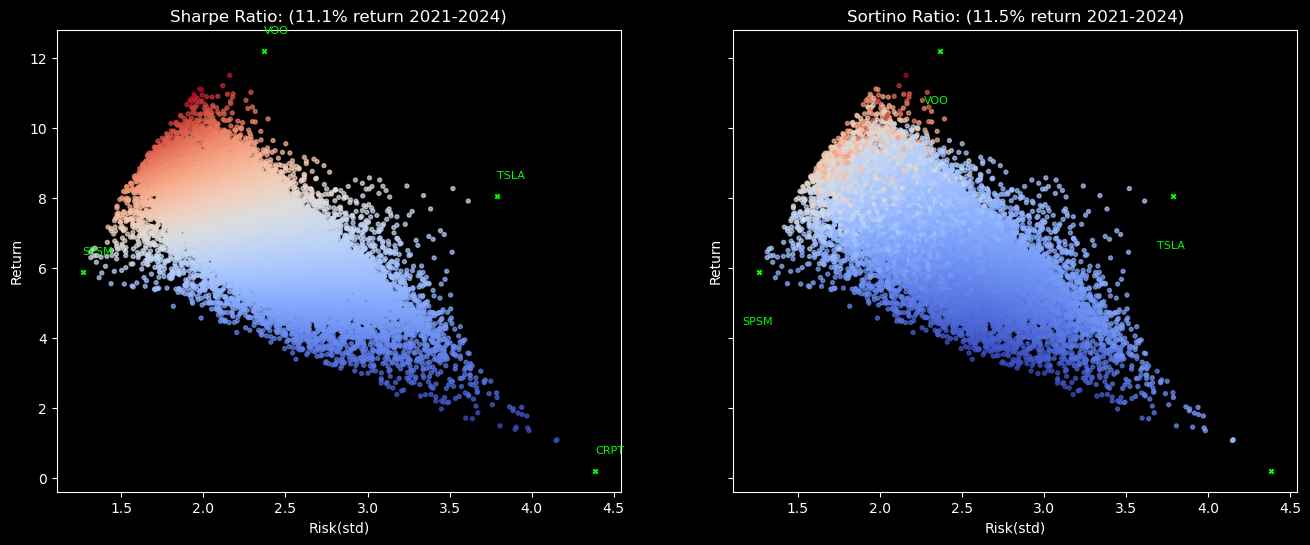

In [12]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(16, 6))
axes[0].scatter(summary.loc[:, "Risk"], summary.loc[:, "Return"]*100, s=10, marker="x", c="lime")
axes[0].scatter(port_summary.loc[:, "Risk"], port_summary.loc[:, "Return"]*100, s=8, c=port_summary.loc[:, "Sharpe"], cmap="coolwarm",
    vmin=port_summary.Sharpe.min(), vmax=port_summary.loc[msrp].Sharpe, alpha=.7)
for i in summary.index:
    axes[0].annotate(i, xy=(summary.loc[i, "Risk"]+0.0002, summary.loc[i, "Return"]*100+.5), size=8, c="lime")

axes[1].scatter(summary.loc[:, "Risk"], summary.loc[:, "Return"]*100, s=10, marker="x", c="lime")
axes[1].scatter(port_summary.loc[:, "Risk"], port_summary.loc[:, "Return"]*100, s=8, c=port_summary.loc[:, "Sortino"], cmap="coolwarm",
    vmin=port_summary.Sortino.min(), vmax=port_summary.loc[msrp1].Sortino, alpha=.7)
for i in summary.index:
    axes[1].annotate(i, xy=(summary.loc[i, "Risk"]-0.1, summary.loc[i, "Return"]*100-1.5), size=8, c="lime")

axes[0].set_xlabel('Risk(std)')
axes[0].set_ylabel('Return')
axes[1].set_xlabel('Risk(std)')
axes[1].set_ylabel('Return')

axes[0].set_title(f"Sharpe Ratio: ({port_summary.loc[msrp].Return*100:.1f}% return {str(start)[:4]}-{end[:4]})")
axes[1].set_title(f"Sortino Ratio: ({port_summary.loc[msrp1].Return*100:.1f}% return {str(start)[:4]}-{end[:4]})")
plt.show()

In [13]:
# Today's liquidation
s0 = 0
for v in range(100):
    ploc = int(v*(prices.shape[0]/100))
    df = (prices/prices.iloc[ploc]).dropna()
    df['Sharpe'], df['Sortino'] = (df.iloc[:,:len(msrp_w)] * msrp_w).sum(axis=1), (df.iloc[:,:len(msrp1_w)] * msrp1_w).sum(axis=1)
    ratios = (ann_risk_return(df.iloc[ploc:,-2:])['Return']*100)[-2:].values
    s0 = s0 + 1 if ratios[0] > ratios[1] else s0 -1
model = 'Sharpe' if s0 > 0 else 'Sortino'
print(f"{abs(s0)}% of samples in favor of {model}")

18% of samples in favor of Sortino


In [14]:
# Range of liquidations, start prices
s0 = 0
for v in range(99, 0, -1):
    ploc = int(v * (prices.shape[0] / 100))
    if ploc < 2:
        continue
    df = (prices / prices.iloc[0]).dropna()
    df['Sharpe'], df['Sortino'] = (df.iloc[:,:len(msrp_w)] * msrp_w).sum(axis=1), (df.iloc[:,:len(msrp1_w)] * msrp1_w).sum(axis=1)
    ratios = (ann_risk_return(df.iloc[:ploc,-2:])['Return']*100)[-2:].values
    s0 = s0 + 1 if ratios[0] > ratios[1] else s0 -1
model = 'Sharpe' if s0 > 0 else 'Sortino'
print(f"{abs(s0)}% of samples in favor of {model}")

11% of samples in favor of Sortino


In [15]:
fig = make_subplots(rows=1, cols=2, subplot_titles=("Price Correlation", "% Change Correlation"))#, "Price Covariance"))
kw = {
    'x':prices.columns,
    'y':prices.columns,
    'colorscale': "Jet",
    'showscale':False,
}
f1 = go.Heatmap(name='Correlation', z=prices.corr(), zmid=0.0, **kw)
f2 = go.Heatmap(name='% Changes Correlation', z=prices.pct_change().corr(), zmid=0.0, **kw)
# f3 = go.Heatmap(name='Price Covariance', z=prices.cov(), zmid=0.0, **kw)

fig.add_trace(f1, row=1, col=1)
fig.add_trace(f2, row=1, col=2)
# fig.add_trace(f3, row=1, col=3)
fig.update_layout(template=template, height=500, width=1000, margin=dict(l=10, r=10, b=10, t=20))
fig.update_yaxes(autorange="reversed")
fig.show()

In [16]:
ms = range(20, 101, 10)
dfmd = pd.DataFrame(index = ms, columns=idx['Adj Close'].columns)

for finish in ms:
    n, best = min([3, len(idx['Adj Close'].columns)//2]), {c:0 for c in idx['Adj Close'].columns}
    for v in range(100):
        t0 = int(v * (prices.shape[0] * finish / 100 / 100)) # Starting time for comparison
        df = (prices.iloc[:int((prices.shape[0] * finish / 100))] / prices.iloc[t0]).dropna() # DataFrame normalized against Starting time prices
        if t0 + 1 >= df.shape[0]:
            continue
        ratios = ann_risk_return(df.iloc[int(v * (df.shape[0] / 100)):])['Return'][:-2] * 100
        for x in ratios.nlargest(n).index:
            best[x] = 1 if not x in best else best[x]+1
    summary['Top'] = [best[x] for x in sorted(best)] # Sample 100 intervals' to date for top N returns
    weight = 'weight' if model == 'Sharpe' else 'weight1'
    dfmd.loc[finish] = [best[x] for x in sorted(best)]
    
dfmd.index = [str(prices.iloc[int(prices.shape[0] * x / 100)].name)[:10] for x in range(10, 100, 10)]
px.imshow(dfmd.T, template=template, color_continuous_scale=px.colors.sequential.Viridis, color_continuous_midpoint=55,
          title=f"In Top {n} Performers {dfmd.index[0]} ... {dfmd.index[-1]}")

TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Index'

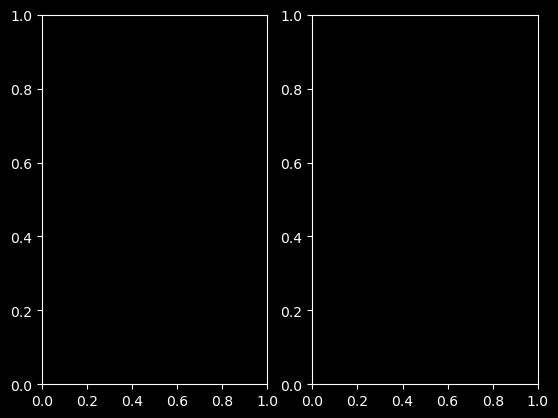

In [17]:
fig, (ax1, ax2) = plt.subplots(1,2)
# SHARPE
# p_tr = prices['sharpe'].tz_convert(None).resample("ME").last()
p_tr = prices['sharpe'].resample("ME").last()
p_ret = np.log(p_tr / p_tr.shift()).dropna().to_frame()
p_ret.columns = ["Return"]
windows = [year for year in range(p_ret.index.size, 0, -1)]
for period in windows:
    p_ret["#{}".format(period)] = p_ret.Return.rolling(period).mean()
triangle = p_ret.drop(columns = ["Return"])
triangle.index = triangle.index.to_period('M')
sns.heatmap(triangle, annot=False, cmap="RdYlGn", vmin=-0.2/12, vmax=0.2/12, center=0, cbar=False, ax=ax1)
# SORTINO
p_tr = prices['sortino'].tz_convert(None).resample("ME").last()
p_ret = np.log(p_tr / p_tr.shift()).dropna().to_frame()
p_ret.columns = ["Return"]
windows = [year for year in range(p_ret.index.size, 0, -1)]
for period in windows:
    p_ret["#{}".format(period)] = p_ret.Return.rolling(period).mean()
triangle = p_ret.drop(columns = ["Return"])
triangle.index = triangle.index.to_period('M')
sns.heatmap(triangle, annot=False, cmap="RdYlGn", vmin=-0.2/12, vmax=0.2/12, center=0, cbar=False, ax=ax2)
# plt.figure(figsize=(80,50))
plt.tick_params(axis = "y", labelright =True, labelleft=False, grid_alpha=.5)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

In [ ]:
v=0
log=True
df = (prices/prices.iloc[int(v*(prices.shape[0]/100))]).dropna()
ar = ann_risk_return(df.iloc[int(v*(prices.shape[0]/100)):])
layout = dict(
    title="Normalized Returns since {}. Sharpe: {:.1f}%. Sortino: {:.1f}%. Max: {:.1f} ({})".format(
        str(prices.iloc[int(v*(prices.shape[0]/100))].name)[:10],
        ar.iloc[-2]['Return']*100,
        ar.iloc[-1]['Return']*100,
        ar.Return.iloc[ar.Return.argmax()]*100,
        ar.iloc[ar.Return.argmax()].name
    ),
    log_y=True,
    template=template
)
px.line(df, **layout)

In [ ]:
slider = widgets.IntSlider(min=20, max=100, value=100, step=20)
def print_val(finish):
    n, best = min([3, len(idx['Adj Close'].columns)//2]), {c:0 for c in idx['Adj Close'].columns}
    for v in range(100):
        t0 = int(v * (prices.shape[0] * finish / 100 / 100)) # Starting time for comparison
        df = (prices.iloc[:int((prices.shape[0] * finish / 100))] / prices.iloc[t0]).dropna() # DataFrame normalized against Starting time prices
        ratios = ann_risk_return(df.iloc[int(v * (df.shape[0] / 100)):])['Return'][:-2] * 100
        largest_values = ratios.nlargest(n)
        for x in largest_values.index:
            best[x] = 1 if not x in best else best[x]+1
    weight = 'weight' if model == 'Sharpe' else 'weight1'
    return px.bar(summary, title=f"In Top {n} Performers {str(df.iloc[0].name)[:10]} ... {str(df.iloc[-1].name)[:10]}", color=category,
                  y=[best[x] for x in sorted(best)], template=template, opacity=[(x/max(summary[weight]))**.5 for x in summary[weight]])
interact(print_val,finish=slider);

## Pricing ##

In [ ]:
fig = go.Figure()
fig.add_trace(go.Bar(x=summary.index, y=summary['SystRisk'], name='SystRisk'))
fig.add_trace(go.Bar(x=summary.index, y=summary['UnsystRisk'], name='UnsystRisk'))
fig.update_layout({
    # 'barmode': 'stack',
    'title': "Risks",
    'template': template,
    'yaxis': {'title_text': "Risk"}
})
fig

In [ ]:
options = ['alpha', 'beta', 'Risk', 'SystRisk', 'UnsystRisk', 'TotalRisk', 'Sharpe', 'capm_ret']
slider = widgets.IntSlider(min=1, max=len(options))
def print_val(v):
    titles = (f"Sharpe Portfolio Components Return vs {options[v-1]}: {port_summary.loc[msrp].Return*100:.1f}% {start[:4]}-{end[:4]}",
            f"Sortino Portfolio Components Return vs {options[v-1]}: {port_summary.loc[msrp1].Return*100:.1f}% {start[:4]}-{end[:4]}")
    fig = make_subplots(rows=2, cols=1, shared_xaxes=True, shared_yaxes=True, subplot_titles=titles)
    kw = {
        'hovertext': summary.index,
        'x':summary[options[v-1]],
        'y':summary['Return'],
        'mode':'markers',
        'marker':dict(size=summary['weight']+1, color=pd.factorize(summary['category'])[0]),
        'showlegend': False,
    }
    kw1 = {
        'hovertext': summary.index,
        'x':summary[options[v-1]],
        'y':summary['Return'],
        'mode':'markers',
        'marker':dict(size=summary['weight1']+1, color=pd.factorize(summary['category'])[0]),
        'showlegend': False,
    }
    f1 = go.Scatter(**kw)
    f2 = go.Scatter(**kw1)
    
    fig.add_trace(f1, row=1, col=1)
    fig.add_trace(f2, row=2, col=1)
    fig.update_layout(template=template, height=500, width=1000, margin=dict(l=10, r=10, b=10, t=30))
    return fig

interact(print_val,v=slider);

## Sectors ##

In [ ]:
# Sector coverage in funds
for i in range(summary.shape[0]):
    try: # fund_sector_weightings fails for certain funds, need to find one that succeeds
        if not any(tickers[summary.index[i]].fund_sector_weightings):
            continue
    except:
        continue
    break
snames = tickers[summary.index[i]].fund_sector_weightings.index
sectors=pd.DataFrame([
    funds[fund]["topHoldings"]['sectorWeightings'] if funds[fund].get("topHoldings",{}).get('sectorWeightings') else len(snames) * [None]
    for fund in funds
], index=summary.index, columns=snames).replace(to_replace=[None], value=[dict({'none': 0.0})])
for c in sectors.columns:
    sectors[c] = [v for d in sectors[c].values for v in d.values()]
sectors = sectors.T
sectors['sharpe']=(sectors * msrp_w).sum(axis=1)
sectors['sortino']=(sectors * msrp1_w).sum(axis=1)
sectors.sort_index(inplace=True)
px.imshow(sectors*100, template=template, title='Top Sectors')

## Overlaps ##

In [ ]:
g = net.Network(notebook=True, bgcolor='#111111', font_color='white', width="100%", height="800px")#, cdn_resources='in_line')
# g.repulsion()
g.physics = "forceAtlas2Based"
# g.inherit_edge_colors(False)
nxg=nx.complete_graph(0)
for n in summary.index: # FIXME: colors of edges
    kw = {'label':n, 'shape':'box'} #'size':abs(summary.loc[n, 'Return'])*100
    kw['title'] = textwrap.fill(funds[n]['summaryProfile'].get('longBusinessSummary', funds[n]['summaryProfile'].get('description')), 60)
    if summary.loc[n, 'Return'] < 0:
        kw['color'] = 'red'
    kw['borderWidth'] = abs(summary.loc[n]['Return']) * 100
    kw['group'] = summary.loc[n]['category']
    nxg.add_node(n, **kw)
    for h in funds[n].get('topHoldings',{}).get('holdings',{}):
        nxg.add_node(h['symbol'], label=h['holdingName'], shape='text')
        nxg.add_edge(n, h['symbol'], value=h['holdingPercent'], title=f"{100*h['holdingPercent']:.1f}%")
g.from_nx(nxg)
g.show("overlaps.html")

### Obsolete

## Recommendations ##

In [ ]:
# Price correlation
def reg_coef(x, y, label=None, color=None, cmap=None, **kwargs):
    ax = plt.gca()
    r, _ = stats.pearsonr(x, y)
    norm = plt.Normalize(-1, 1)
    cmap = cmap if not cmap is None else plt.cm.coolwarm
    ax.annotate(f"{r:.2f}", xy=(0.5, 0.5), xycoords='axes fraction', ha='center', fontsize=16, bbox={'facecolor': cmap(norm(r)), 'alpha': r**4})
    ax.set_axis_off()

return_fig = sns.PairGrid(prices)
# Using map_upper we can specify what the upper triangle will look like.
return_fig.map_upper(plt.scatter, color='purple')
return_fig.map_upper(reg_coef, cmap=plt.get_cmap('PiYG'))

# We can also define the lower triangle in the figure, inclufing the plot type (kde) or the color map (BluePurple)
return_fig.map_lower(sns.kdeplot, cmap='cool_d')
# Finally we'll define the diagonal as a series of histogram plots of the daily return
return_fig.fig.suptitle('Price Correlation', fontsize=24)
return_fig.map_diag(plt.hist, bins=24);

---

## Screener

In [ ]:
droplist = " ".join((TEST, " ".join((categories.values()))))
shortlist = [x for x in ({rec['symbol'] for r in recommendations.values() for v in r.values() for rec in v['recommendedSymbols'] if not (rec['symbol'] in droplist)})]
profiles = {n:Ticker(n).fund_profile[n] for n in shortlist}
for prop in ['maxAge', 'styleBoxUrl']:
    for k,v in profiles.items():
        if prop in v:
            del v[prop]
shortlist = [p for p, v in profiles.items() if 'categoryName' in v and not 'Leveraged' in v['categoryName']]
" ".join(sorted({*shortlist}))

In [ ]:
# Recommendations
g = net.Network(notebook=True, bgcolor='#111111', font_color='white', width="100%", height="800px")#, cdn_resources='in_line')
g.repulsion()
g.physics = "forceAtlas2Based"
nxg=nx.complete_graph(0)
for n in summary.index:
    kw = {'label':n, 'shape':'box'}
    kw['group'] = summary.loc[n]['category']
    kw['title'] = textwrap.fill(funds[n]['summaryProfile'].get('longBusinessSummary', funds[n]['summaryProfile'].get('description')), 60)
    nxg.add_node(n, **kw)
    for h in list(recommendations[n].values())[0]['recommendedSymbols']:
        if not h['symbol'] in shortlist:
            continue
        nxg.add_node(h['symbol'], label=h['symbol'], shape='text', title=json.dumps(profiles[h['symbol']], indent=2))
        nxg.add_edge(n, h['symbol'], value=h['score'], title=100*h['score'])
g.from_nx(nxg)
g.show("recommendations.html")

In [ ]:
s = Screener()
print([x for x in s.available_screeners if 'etf' in x and not 'asia' in x and not 'europe' in x])

In [ ]:
screener = ['fifty_two_wk_losers_etfs', 'cheapest_etfs', 'top_etfs_us'] #'top_performing_etfs', 'precious_metal_etfs'
def g(row):
    return [str(r) for r in row.values]
    
def bold_row(row):
    return ['font-weight: bold' if 'ChangePercent' in row.name else '' for v in row]

def bold_index(s):
    return '<b>{}</b>'.format(s)

def h_hi(row):
    return ['background-color: lightgreen']*len(row.values) if 'ChangePercent' in row.name else ['']*len(row.values)

droprows=["shortName", 'exchange', 'firstTradeDateMilliseconds', 'messageBoardId', 'dividendDate', 'fiftyTwoWeekLowChangePercent', 'fiftyTwoWeekHighChangePercent',
        'fiftyDayAverageChangePercent', 'twoHundredDayAverageChangePercent', 'fiftyTwoWeekLowChange', 'fiftyTwoWeekHighChange', 'regularMarketChange', 'isEarningsDateEstimate',
        'postMarketChangePercent', 'askSize', 'bidSize', 'ipoExpectedDate', 'epsTrailingTwelveMonths', 'sharesOutstanding', 'bookValue', 'marketCap', 'netAssets']
quotes = [i for q in s.get_screeners(screener, 48).values() for i in q['quotes'] if not i['symbol'] in droplist]
df = pd.json_normalize(quotes).set_index('symbol').T
df.drop(df.index[:7], inplace=True)
df.drop([c for c in df.index if 'Time' in c], inplace=True)
regex = re.compile('|'.join(['everage', "Ether", 'Bitcoin', 'Bond', "Ultra", "Short", "Long", 'Hedge', 'Option', 'Covered Call', 'Treasury', "Trust", "Daily", "Monthly", 'Weekly', 'Asia', 'China', 'Emerging', 'iShares MSCI']))
df.drop([c for c in df.columns if regex.search(df.loc['longName', c])], axis=1, inplace=True)
    
for i in df.index:
    if 1 == len(set(g(df.loc[i,:]))):
        droprows.append(i)
df.drop(droprows, inplace=True, errors='ignore')
df = df.sort_values(by=['fiftyTwoWeekChangePercent'], axis=1, ascending=False)
df = df.fillna('')

df.drop(droplist, axis=1, errors='ignore', inplace=True)
df.head(60).style.apply(h_max, axis=1).apply(h_min, axis=1).apply(bold_row, axis=1).apply(h_hi, axis=1)

In [ ]:
df.columns 

In [ ]:
" ".join(df.columns)

## Algo Return

In [ ]:
algo=(1 + idx['Adj Close'].pct_change() * idx['position'].shift(1)).cumprod()
px.line(algo, template=template, log_y=True, title="Algo")

## Timestamp

In [ ]:
datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")